# Theory of Prophet - GAM Model

### Generalized Additive Models: 

Until now, we have tried to use past values to predict the values of time series at time t. However, we will now consider an approach where we decompose the time series into functions that add together to reproduce the original series. This approach casts the time series problem as curve fitting, which does incur some trade-offs. On the upside, it renders the model interpretable, easy to debug, and able to handle missing and irregularly spaced observations. On the other hand, we are likely to lose some accuracy, as compared to autoregressive approaches that consider the previous few (or many) data points for each next prediction.

Generalized additive terms replace the terms in linear regression with smooth functions of the predictors.  The form of those functions determines the structure, and thus flexibility, of the model. When applied to univariate time series, the observed variable is deconstructed into smooth functions of time. There are some functions that are common to many time series, which we will outline here. Schematically, the model we are describing looks something like this:

	observation(t) = trend(t) + seasonality (t) + impact_effect (t) + noise (t)


### Prophet vs Autoregression Models (AR, MA, ARMA, ARIMA, ARIMAX) 

1. Autoregressive models assume a linear relationship between the lagged values and the current value (as we saw from the all the equations before). This assumption may not always hold in real-world scenarios where the relationship might be nonlinear. GAMs, on the other hand, are more flexible and can capture nonlinear relationships using smooth functions.


2. Autoregression restricts our ability to forecast far into the future. In order to regress on values, we must have those values. Using one-step ahead forecasting repeatedly is likely to compound forecasting errors very quickly, since we’re regressing on our own predictions.


3. From our discussion on stationarity and Autoregression models, it is clear that all these model assumes that the time series data is stationary or can be transformed into a stationary series through differencing. Therefore, these model works only with *stationary series*. A great advantage of using Prophet over autoregressive models (eg. ARIMA) is that Prophet doesn’t require stationary time series: a trend component is generated natively. Furthermore, since it does not remove the trend component of the time series, FB-Prophet learns the trend as well. One of the strengths of Prophet is also a weakness for the stability of the results and the performance however - The trend component tends to explain the vast majority of the prediction — around 90%. Thus, if the trend is not well estimated, performance will dramatically drop and you can lose over 20 points of MAPE by over or under predicting over time.N


### Modelling Trend

Many possible functions could be used to model trend, so selecting an appropriate function is up to the modeler. For instance, it may be apparent from the data that the observed quantity is growing exponentially—in which case, an exponential function of time would be fitting. When the trend of a time series is more complex than overall increase or decline, it may be modeled in a piecewise fashion. It is possible to model very nonlinear global tendencies with piecewise linear approximations, but we must be careful not to overfit; after all, any function may be approximated well with small enough linear segments. 

### Modelling Seasonality 

To encode arbitrary periodic patterns, we need a flexible periodic function. Any periodic function can be approximated by Fourier series. We can tune how flexible the periodic function is by increasing the degree of the approximation (increasing the number of sine and cosine terms included). A Fourier expansion guarantees the periodicity of the component; the end of a cycle transitions smoothly into the start of the next cycle. 

Generalized additive models may have multiple seasonal components, each having its own periodicity. For instance, there may be a repeating annual cycle, weekly cycle, and daily cycle, all active in the same time series.

### Modelling Impact

Some time series have discrete impact effects, active only at specific times. For instance, we know that that our data is going to change depending upon wheather it is a weekend or a weekday and the impact of holidays.  We can model such discrete impact effects by including a constant term for them in the model, but having that term only be active at the appropriate time. Then, the coefficient of the term quantifies the additional effect (positive or negative) of it being a certain day (or hour, or other time period), having accounted for the seasonal and trend components. 

### Incorporating External Regressors

When modeling electricity demand, as we do below, we could include outdoor temperature as an external regressor that is likely to carry a lot of information (in our example, we do not do this, though we could almost certainly improve our ultimate metrics by doing so).

There are a few things to bear in mind when adding regressors. The first is the interpretability of the prediction. Each forecast value is the sum of the components active at that point. Including extra regressors makes interpretation of the model a little more complicated, since the prediction no longer depends only on time, but also on the values of extra regressors. Whether the more subtle interpretation is a worthwhile trade-off for increased predictive power is a decision the modeler will need to make, based on the problem they need to solve.

Second, including external regressors often introduces another forecasting problem. If we would like to predict what the electricity demand will be next week, and we rely on temperature as a predictor, we’d better know what the temperature will be next week! Whereas some predictors may be known ahead of time—the day of week for instance, or whether the day is a national holiday—many predictors must themselves be forecast. Naturally occurring examples (that relate to our electricity demand forecast example) include temperature, humidity, or wind speed, but any feature that we do not have reliable knowledge of ahead of time engenders this problem.


### The Bayesian Nature of FBProphet

One thing that we would like to talk about before we dive into the code is that FBProphet uses Bayesian Inference to estimate the posterior distribuition of the model. This is done using a Markov Chain Monte Carlo (MCMC) algorithm, which samples from the posterior distribution of the model parameters. 

Essentially, the entire posterior probability is estimated which means that the result gives an error of margin around what the parameters could be (similar to Bayesian linear regression where you get a collection of slopes and intercept as an estimate rather than a single slope or intercept) 



### Implementing All Lose Functions 

In [10]:

#copying all the relevent loss functions. we already made them when exploring the dataset.  

#######################implementing Mape ################################
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

########################implementing RMSE ##############################

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    return rmse

#################### implementing Peak Load ############################

def peak_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_load_true = np.max(y_true)
    plape = np.abs((peak_load_true - np.max(y_pred)) / peak_load_true) * 100
    return plape

################## implementing Valey load ##############################

def value_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_min_true = np.min(y_true)
    vlape = np.abs((peak_min_true - np.min(y_pred)) / peak_min_true) * 100
    return vlape


################# implementing Energy absolute percent error #############


def energy_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total_energy_true = np.sum(y_true)
    total_energy_pred = np.sum(y_pred)
    eape = np.abs((total_energy_true - total_energy_pred) / total_energy_true) * 100
    
    return eape

# Relevant Imports 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

C:\Users\AWCD\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Visualizing the entire dataset decomposition 

From the decomposition, we see that whenever the trend increases, the seasonality increases. As such, we will set **seasonality_mode ="multiplicative".** However, the increase in accuracy is minimal for the simple prophet model as we can see below in the experiment. However, when you set seasonality_mode to multiplicative, the effect of holiday effect is also strengthed. Therefore in the 2nd experiment of incorporating the effect of holidays, we once again use this configuration and see if there is any accuracy. 

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


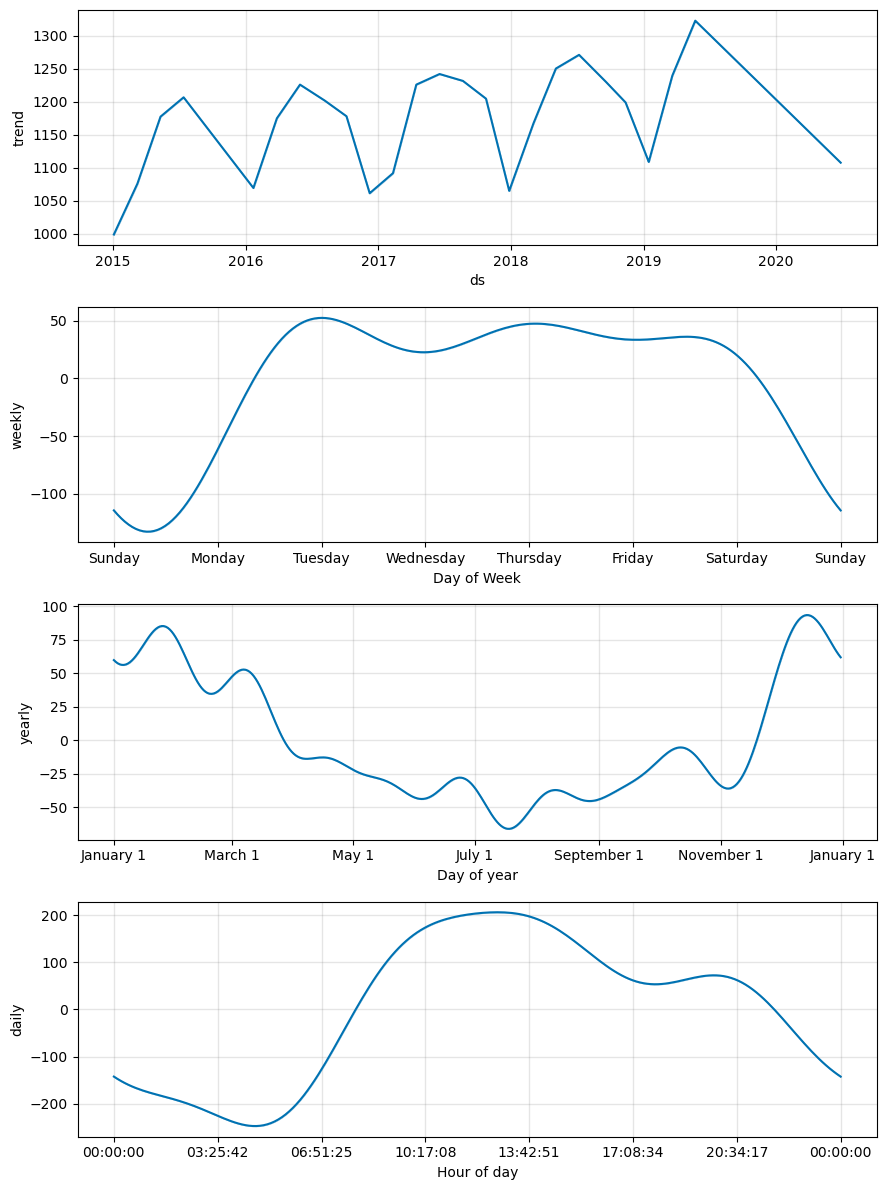

In [4]:
df = pd.read_csv(r"C:\Users\AWCD\OneDrive\Desktop\Machine Learning Project\Archive\continuous_dataset.csv")
df = df.set_index("datetime")
df_viz = df["nat_demand"]


df_viz = df_viz.reset_index().rename(columns = {"datetime":"ds",
                                           "nat_demand":"y"})

model = Prophet()
model.fit(df_viz)
fig = model.plot_components(model.predict(df_viz))
plt.show()

## Implementing Prophet: 


In [2]:
train_dict = pd.read_excel(open('train_dataframes.xlsx', 'rb'), sheet_name = None, index_col=0)
# Import a dictionary with all the testing dataframes
test_dict = pd.read_excel(open('test_dataframes.xlsx', 'rb'), sheet_name = None, index_col=0)
keys = list(train_dict.keys())


In [4]:
train = train_dict[keys[0]]
test = test_dict[keys[0]]

print(train.head(5))
print(len(train)) # We should obtain 36721
print(len(test)) # We should obtain 168


                     week_X-2  week_X-3  week_X-4      MA_X-4  dayOfWeek  \
datetime                                                                   
2015-01-31 01:00:00  962.2865  906.9580  970.3450  938.004850          1   
2015-01-31 02:00:00  933.3221  863.5135  912.1755  900.284075          1   
2015-01-31 03:00:00  903.9817  848.4447  900.2688  881.704325          1   
2015-01-31 04:00:00  900.9995  839.8821  889.9538  876.458825          1   
2015-01-31 05:00:00  904.3481  847.1073  893.6865  879.190775          1   

                     weekend  holiday  Holiday_ID  hourOfDay    T2M_toc  \
datetime                                                                  
2015-01-31 01:00:00        1        0           0          1  25.308496   
2015-01-31 02:00:00        1        0           0          2  25.141443   
2015-01-31 03:00:00        1        0           0          3  25.006738   
2015-01-31 04:00:00        1        0           0          4  24.899713   
2015-01-31 05:00:

## A simple Prophet Model - for single train-test split

Initially we are going to implement Prophet Model without incorporating any of the features given in the dataset and evaluate the performance of the model. 

1. Prophet Model expects the dataset to be named in a specific way:

- Datetime column named: ds
- target : y 


In [8]:
#transforming our data so it only contains the target feature and datetime: 
train = train[ "DEMAND"]
test = test[ "DEMAND"]

train.head()

#now performing a transformation to rename the columns: 

train_prophet = train.reset_index().rename(columns = {"datetime":"ds",
                                           "DEMAND":"y"})

test_prophet = test.reset_index().rename(columns = {"datetime":"ds",
                                           "DEMAND":"y"})

train_prophet.head()

,ds,y
0,2015-01-31 01:00:00,954.2018
1,2015-01-31 02:00:00,913.8660
2,2015-01-31 03:00:00,903.3637
3,2015-01-31 04:00:00,889.0806
4,2015-01-31 05:00:00,910.1472


In [9]:
# Training the model is easy. We invoke the Prophet () object from the prophet module
# For one model we are going to keep the parameters as default. 

# On the other hand, for the second model we are going to turn daily_seasonality on because our data is periodic
# for 24 hours. This may help improve accuracy. Edit:it turns out it does not so I am not incorporating it. 

model = Prophet()
model.fit(train_prophet)

model_seasonality = Prophet(seasonality_mode ="multiplicative")
model_seasonality.fit(train_prophet)


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [10]:
##lets predict on our test data
forcasted = model.predict(test_prophet)
forcasted.head()

forcasted_seasonality = model_seasonality.predict(test_prophet)




When you observe the data, notice that the dataframe has more than just the output prediction. This is an additive model. Hence, its showing us each of the components of the prediction in our output.
**For now, we just run our data as it is but we will explore EACH OF THESE COMPONENTS**


### Visualizing

Although it is not that noticeable here, the model actually has the upper and lower bounds of what the model thinks its reasonable for a prediction into the future. This is because we essentially have a Bayesian inference with Prophet where the entire posterior distribuition is estimated using Markov Chain model rather than a single value. 

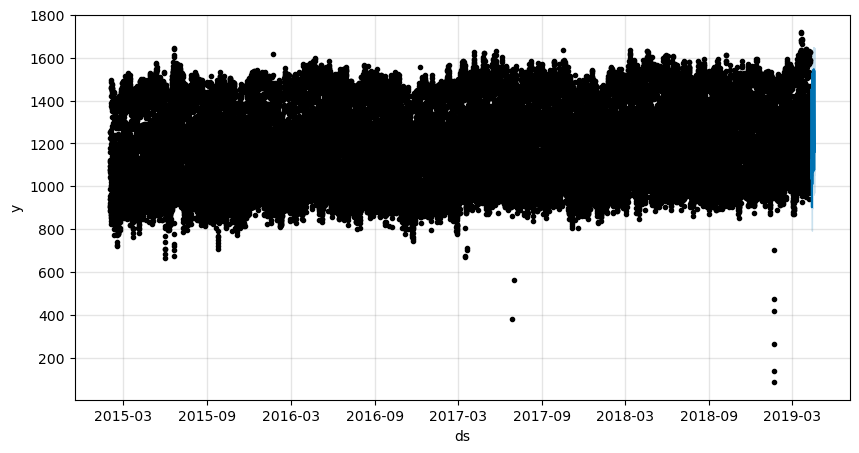

In [11]:
fig, ax = plt.subplots(figsize = (10,5))
fig = model.plot(forcasted, ax = ax)
plt.show()

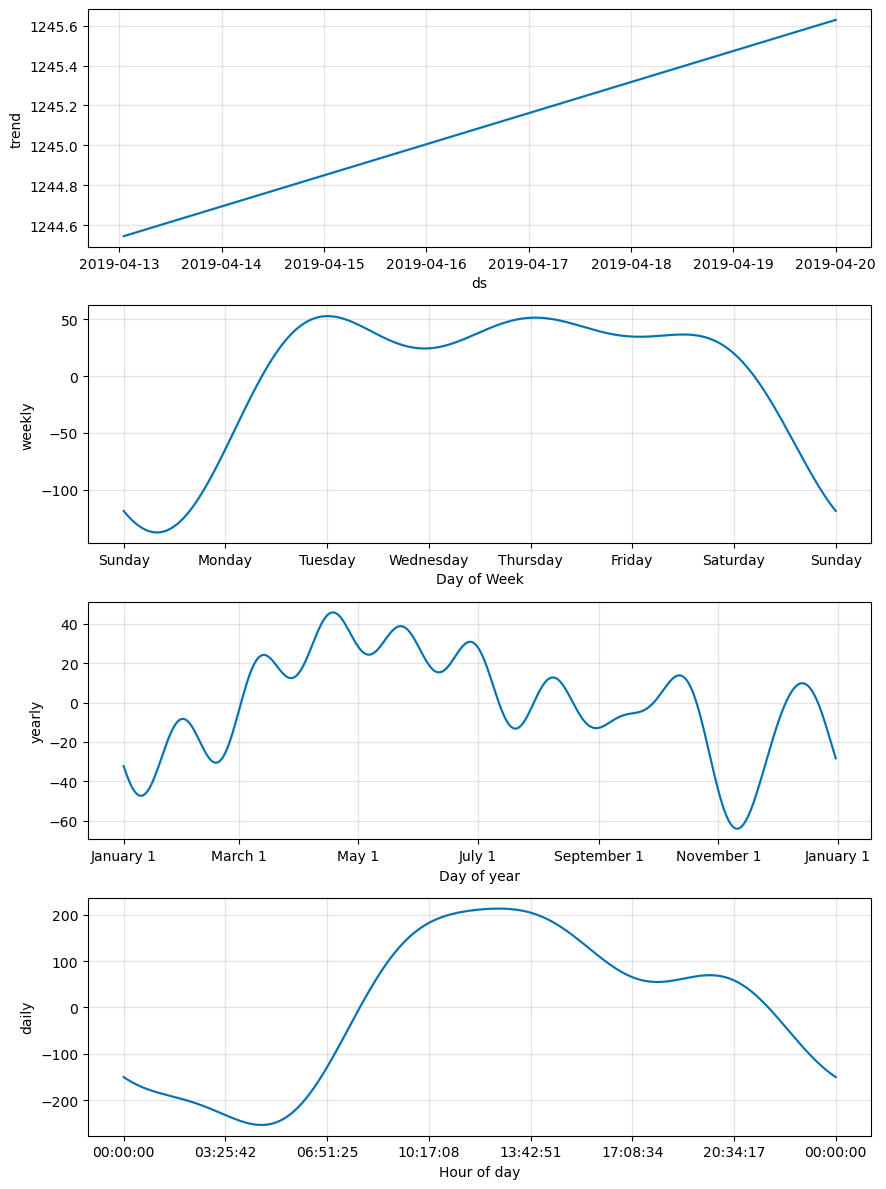

In [12]:
fig = model.plot_components(forcasted)
plt.show()

# Comparing Forecasts to Actuals

We will now run some evaluation metrics to see how well the model actually did in comparing. We'll compare the forecasts to actuals by plotting the actual values alongside our model predicted values.


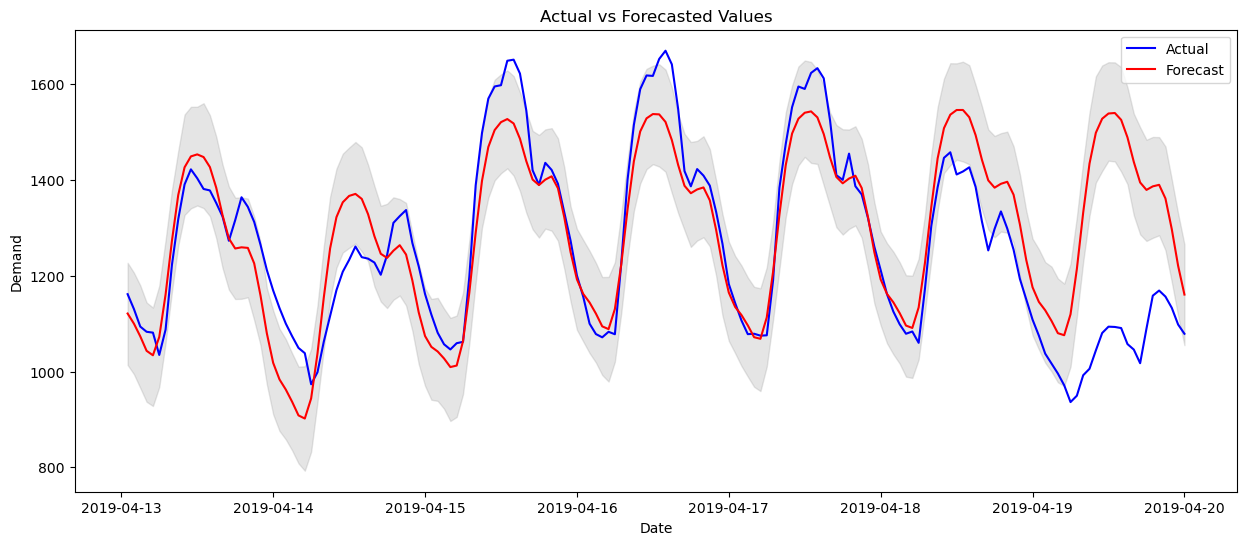

In [13]:
plt.figure(figsize=(15, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual', color='blue')
plt.plot(forcasted['ds'], forcasted['yhat'], label='Forecast', color='red')
plt.fill_between(forcasted['ds'], forcasted['yhat_lower'], forcasted['yhat_upper'], color='gray', alpha=0.2)
plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

## Evaluate the model with Error Metrics

In [14]:
mape_score = mean_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
rmse_score = root_mean_squared_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
plape_score = peak_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
vlape_score = value_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
eape_score = energy_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])

print("Metrics for single train-test split:")
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)


mape_score = mean_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
rmse_score = root_mean_squared_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
plape_score = peak_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
vlape_score = value_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
eape_score = energy_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])

print("Metrics for single train-test split with seasonality on:")
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)



## As we can see, there is no big difference with turning seasonality on and off. This is true for all datasets if you try it.
# Therefore, I will not incorporate it. 


Metrics for single train-test split:
MAPE:  7.77
RMSE: 134.85308532185212
PLAPE: 7.41134694422847
VLAPE: 3.6715388933178406
EAPE: 2.222498669136449
Metrics for single train-test split with seasonality on:
MAPE:  7.87
RMSE: 134.99977297258644
PLAPE: 7.313169502682585
VLAPE: 6.795358670157807
EAPE: 1.3802927125446052


# A simple Prophet model for entire dataset

In [15]:
mape_simple = []
rmse_simple = []
plape_simple = []
vlape_simple = []
eape_simple = []

mape_seasonal = []
rmse_seasonal = []
plape_seasonal = []
vlape_seasonal = []
eape_seasonal = []



for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]
    train_simple = train[ "DEMAND"]
    test_simple = test[ "DEMAND"]
    train_prophet = train_simple.reset_index().rename(columns = {"datetime":"ds",
                                           "DEMAND":"y"})
    test_prophet = test_simple.reset_index().rename(columns = {"datetime":"ds",
                                           "DEMAND":"y"})
    model = Prophet()
    model.fit(train_prophet)
    forcasted = model.predict(test_prophet)
    mape_score = mean_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
    rmse_score = root_mean_squared_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
    plape_score = peak_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
    vlape_score = value_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
    eape_score = energy_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted['yhat'])
    
    mape_simple.append(mape_score)
    rmse_simple.append(rmse_score)
    plape_simple.append(plape_score)
    vlape_simple.append(vlape_score)
    eape_simple.append(eape_score)
    
    
    model_seasonality = Prophet(seasonality_mode ="multiplicative")
    model_seasonality.fit(train_prophet)
    forcasted_seasonality = model_seasonality.predict(test_prophet)

    mape_score = mean_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
    rmse_score = root_mean_squared_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
    plape_score = peak_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
    vlape_score = value_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
    eape_score = energy_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_seasonality['yhat'])
    
    mape_seasonal.append(mape_score)
    rmse_seasonal.append(rmse_score)
    plape_seasonal.append(plape_score)
    vlape_seasonal.append(vlape_score)
    eape_seasonal.append(eape_score)
    
    


"""
##################################################################################################################
################################ Printing Metrics #####################################################
##################################################################################################################
"""


print("Metrics:")
print("MAPE: ", mape_simple)
print("RMSE:", rmse_simple)
print("PLAPE:", plape_simple)
print("VLAPE:", vlape_simple)
print("EAPE:", eape_simple)




INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain

Metrics:
MAPE:  [7.77, 3.94, 6.61, 6.72, 5.08, 4.91, 6.23, 8.59, 7.72, 5.35, 3.86, 4.93, 8.91, 7.75]
RMSE: [134.85308532185212, 62.8530837415577, 101.42509786162674, 98.18905102352677, 73.45879118114134, 70.89688334532465, 86.54274821654184, 124.70421712378948, 128.97296195944602, 86.63131583709493, 66.33753747970715, 72.89882842411764, 119.70470271770468, 102.54928538436198]
PLAPE: [7.41134694422847, 4.101252730005055, 11.11897851075676, 6.201355825196481, 7.04347531651864, 4.399445227277829, 0.7480571169732736, 13.272279099529355, 2.6259778080715024, 6.630827777391681, 7.130796394042786, 4.3150338501269285, 2.602579408376462, 1.9046527307930927]
VLAPE: [3.6715388933178406, 5.646330861058392, 10.36127535640624, 10.910951533371636, 0.07820705508183966, 5.874729299675656, 2.5856172267023445, 11.784427753540733, 6.001383358597686, 6.376335372912859, 7.176717764129668, 4.100614509691205, 18.48600299739982, 18.722972226553356]
EAPE: [2.222498669136449, 0.5140252752385963, 5.680802301805047

# Incorporating the effect of Holidays -  for single train-test split

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday effects parameter than can be provided to the model prior to the training. To work with this, we will need to preprocess our original df file (as we do below)

When we were training and incorporating the effect of holidays, the model was not improving on test data. Infact, it was became worse. We then incorporated holidays_prior_scale which essentially controls the strength of the holiday effects. Specifically, it is a hyperparameter that determines the regularization strength on the holiday components in the model.
When it has a high value, the model will give more weight to the holiday effects, potentially capturing specific patterns associated with holidays more closely. We set this regularization term to **2 and therefore give it a less weight**. This leads to drastic improvement in our model's for the single train-test split, but does not give strong results otherwise. Another value that we tried was for 10. Again, there was no improvement. 



*edit: so I read the following on a website: " It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast." . 

- As such, we need to make a holiday_df that incorporates all holidays. That is easy. We can just use the original dataset continious.csv. After we did this, we saw drastic improvement in our model! However, the predictions are still better off without incorporating holiday effects as long as we don't turn on seasonality_mode = yearly. With that, the effects of holiday yield better accuracy. 


In [7]:
##iterate over and find where holiday == 1, then take the Holiday_ID
df = pd.read_csv(r"C:\Users\AWCD\OneDrive\Desktop\Machine Learning Project\Archive\continuous_dataset.csv")
df = df.set_index("datetime")
df.head()

holidays_df = df[df["holiday"] == 1]["Holiday_ID"]

holidays_df.head()


holidays_df = holidays_df.reset_index().rename(columns = {"datetime":'ds' , "Holiday_ID":"holiday"})

##using the metadata associated with the data to convert holiday id into the actual holiday names
holiday_mapping = {
    1: 'New Year',
    2: "Martyrs' Day",
    3: 'Carnival Saturday',
    4: 'Carnival Sunday',
    5: 'Carnival Monday',
    6: 'Carnival Tuesday',
    7: 'Ash Wednesday',
    8: 'Holy Thursday',
    9: 'Good Friday',
    10: 'Holy Saturday',
    11: 'Resurrection Sunday',
    12: 'Labor Day',
    13: 'Foundation of Old Panama',
    14: 'Separation of Panama from Colombia',
    15: 'Flag Day',
    16: 'Patriotic Commemoration in Colón city',
    17: 'First Cry of Independence',
    18: 'Independence of Panama from Spain',
    19: "Mother's Day",
    20: 'Christmas eve',
    21: 'Christmas',
    22: "New Year's Eve"
}


holidays_df['holiday'] = holidays_df['holiday'].map(holiday_mapping)
print(holidays_df.head())
print(len(holidays_df))




                    ds       holiday
0  2015-01-09 00:00:00  Martyrs' Day
1  2015-01-09 01:00:00  Martyrs' Day
2  2015-01-09 02:00:00  Martyrs' Day
3  2015-01-09 03:00:00  Martyrs' Day
4  2015-01-09 04:00:00  Martyrs' Day
3024


In [17]:

holidays_prior_scale_value = 10

model_with_holiday = Prophet(holidays = holidays_df,holidays_prior_scale=holidays_prior_scale_value)
model_with_holiday.fit(train_prophet)


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [18]:
forcasted_with_holiday = model_with_holiday.predict(test_prophet)  

mape_score = mean_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_with_holiday['yhat'])
rmse_score = root_mean_squared_error(y_true=test_prophet['y'], y_pred=forcasted_with_holiday['yhat'])
plape_score = peak_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_with_holiday['yhat'])
vlape_score = value_load_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_with_holiday['yhat'])
eape_score = energy_absolute_percentage_error(y_true=test_prophet['y'], y_pred=forcasted_with_holiday['yhat'])

print("Metrics for single train-test split:")
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)




Metrics for single train-test split:
MAPE:  7.83
RMSE: 103.41961379122547
PLAPE: 2.3346259919470946
VLAPE: 19.04008469469005
EAPE: 3.043825909650172


# Incorporating the effect of Holidays - for entire data

In [19]:
mape_holiday = []
rmse_holiday = []
plape_holiday = []
vlape_holiday = []
eape_holiday = []

for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]
    
    train_holiday = train[ "DEMAND"]
    test_holiday = test[ "DEMAND"]
    
    train_holiday = train_holiday.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
    test_holiday = test_holiday.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
    model_with_holiday = Prophet(holidays = holidays_df)
    model_with_holiday.fit(train_holiday)
    forcasted_with_holiday = model.predict(test_holiday)
    
    mape_score_hol = mean_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    rmse_score_hol = root_mean_squared_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    plape_score_hol = peak_load_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    vlape_score_hol = value_load_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    eape_score_hol = energy_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    
    mape_holiday.append(mape_score_hol)
    rmse_holiday.append(rmse_score_hol)
    plape_holiday.append(plape_score_hol)
    vlape_holiday.append(vlape_score_hol)
    eape_holiday.append(eape_score_hol)


"""
##################################################################################################################
########################################### Printing Metrics #####################################################
##################################################################################################################
"""


print("Metrics:")
print("MAPE: ", mape_holiday)
print("RMSE:", rmse_holiday)
print("PLAPE:", plape_holiday)
print("VLAPE:", vlape_holiday)
print("EAPE:", eape_holiday)


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Metrics:
MAPE:  [7.86, 4.16, 5.92, 6.38, 5.38, 4.7, 6.53, 8.68, 7.42, 5.35, 5.86, 5.79, 8.78, 7.75]
RMSE: [131.667058004651, 64.08762851675402, 94.56609675865894, 95.51858535827803, 78.19711091290662, 67.89492852931122, 90.05632111936707, 125.21457793957084, 123.53582737651698, 86.6826862669398, 92.16371144909667, 94.76277731145258, 118.24843132862817, 102.54928538436198]
PLAPE: [9.616087615481362, 4.202632651533081, 11.105717497790954, 7.435608140961618, 8.882869160813886, 5.425585578262913, 0.9476778092366472, 10.23690471952065, 3.6022060891157235, 6.744321285855979, 10.656035860730983, 11.070637934617551, 2.244456929345697, 1.9046527307930927]
VLAPE: [5.878509169513527, 3.7731016811030207, 8.00131036405323, 10.764831356359256, 1.5104871935296522, 5.935553712246415, 0.9791429812506955, 5.302766907332314, 5.72322243207117, 5.0814198322430855, 10.953511635615133, 12.632494595868652, 18.609788773424498, 18.722972226553356]
EAPE: [0.0912693091809874, 1.0881692125715163, 4.884262630537114

In [20]:
mape_seasonal1 = []
rmse_seasonal1 = []
plape_seasonal1 = []
vlape_seasonal1 = []
eape_seasonal1 = []


for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]
    
    train_holiday = train[ "DEMAND"]
    test_holiday = test[ "DEMAND"]
    
    train_holiday = train_holiday.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
    test_holiday = test_holiday.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
    model_with_holiday = Prophet(seasonality_mode ="multiplicative",holidays = holidays_df)
    model_with_holiday.fit(train_holiday)
    forcasted_with_holiday = model_with_holiday.predict(test_holiday)


    mape_score1 = mean_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    rmse_score1 = root_mean_squared_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    plape_score1 = peak_load_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    vlape_score1 = value_load_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    eape_score1 = energy_absolute_percentage_error(y_true=test_holiday['y'], y_pred=forcasted_with_holiday['yhat'])
    
    mape_seasonal1.append(mape_score1)
    rmse_seasonal1.append(rmse_score1)
    plape_seasonal1.append(plape_score1)
    vlape_seasonal1.append(vlape_score1)
    eape_seasonal1.append(eape_score1)
    

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [21]:
print("Metrics for single train-test split with seasonality on:")
print("MAPE: ", np.mean(mape_seasonal1))
print("RMSE:", np.mean(rmse_seasonal1))
print("PLAPE:", np.mean(plape_seasonal1))
print("VLAPE:", np.mean(vlape_seasonal1))
print("EAPE:", np.mean(eape_seasonal1))

Metrics for single train-test split with seasonality on:
MAPE:  6.0928571428571425
RMSE: 89.59171451566814
PLAPE: 4.687217021390823
VLAPE: 11.243719756437871
EAPE: 2.5092848171169564


# Incorporating the effect of Temperature (T2M_toc) - for single train-test split

We use a multiplicative effect since the impact of temperature is proportional to the temperature level. If the impact of a one-degree increase in temperature is larger when the overall temperature is high (or smaller when it's low), a multiplicative effect might be more appropriate. Multiplicative effects are common when dealing with percentages or proportional relationships. On the other hand, additive relation would be if temperature does nto have effect on electricity demand. 

In [28]:

train = train[["T2M_toc","DEMAND"]]
test = test[["T2M_toc", "DEMAND"]]


train_prophet_temp = train.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y","T2M_toc":"T2M_toc" })
test_prophet_temp = test.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y","T2M_toc":"T2M_toc" })
test_prophet_temp.head()

,ds,T2M_toc,y
0,2020-06-13 01:00:00,25.864984,1010.6531
1,2020-06-13 02:00:00,25.748865,976.2663
2,2020-06-13 03:00:00,25.689111,947.0559
3,2020-06-13 04:00:00,25.674066,930.6396
4,2020-06-13 05:00:00,25.665491,922.1306


In [29]:
model_with_temp = Prophet(seasonality_mode ="multiplicative",holidays = holidays_df)
model_with_temp.add_regressor('T2M_toc',mode='multiplicative') 
#prior scale performs regularization to ensure overfitting does not occur 
model_with_temp.fit(train_prophet_temp)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [30]:
forcasted_with_temp = model_with_temp.predict(test_prophet_temp)


mape_score = mean_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
rmse_score = root_mean_squared_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
plape_score = peak_load_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
vlape_score = value_load_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
eape_score = energy_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])

print("Metrics for single train-test split:")
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)


Metrics for single train-test split:
MAPE:  7.18
RMSE: 95.81490350640296
PLAPE: 5.349897675816585
VLAPE: 15.923321305751312
EAPE: 4.558865435016053


# Incorporating the effect of Temperature (T2M_toc) - for all data


In [31]:
mape_temp = []
rmse_temp = []
plape_temp = []
vlape_temp = []
eape_temp = []

for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]
    
    train = train[["T2M_toc","DEMAND"]]
    test = test[["T2M_toc", "DEMAND"]]
    
    train_holiday = train[ "DEMAND"]
    test_holiday = test[ "DEMAND"]
    
    train_prophet_temp = train.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y","T2M_toc":"T2M_toc" })
    test_prophet_temp = test.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y","T2M_toc":"T2M_toc" })

    
    model_with_temp = Prophet(seasonality_mode ="multiplicative",holidays = holidays_df)
    model_with_temp.add_regressor('T2M_toc',mode='additive') 
    model_with_temp.fit(train_prophet_temp)

    forcasted_with_temp = model_with_temp.predict(test_prophet_temp)


    mape_score = mean_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
    rmse_score = root_mean_squared_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
    plape_score = peak_load_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
    vlape_score = value_load_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])
    eape_score = energy_absolute_percentage_error(y_true=test_prophet_temp['y'], y_pred=forcasted_with_temp['yhat'])


    mape_temp.append(mape_score)
    rmse_temp.append(rmse_score)
    plape_temp.append(plape_score)
    vlape_temp.append(vlape_score)
    eape_temp.append(eape_score)


"""
##################################################################################################################
########################################### Printing Metrics #####################################################
##################################################################################################################
"""


print("Metrics:")
print("MAPE: ", mape_temp)
print("RMSE:", rmse_temp)
print("PLAPE:", plape_temp)
print("VLAPE:", vlape_temp)
print("EAPE:", eape_temp)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Metrics:
MAPE:  [6.15, 4.0, 6.25, 6.16, 4.61, 4.29, 6.53, 7.38, 8.55, 5.62, 3.8, 4.24, 7.77, 7.16]
RMSE: [93.20452601335305, 64.69516050153129, 96.50441668265532, 92.60051107367396, 67.2845286413407, 63.480923994674086, 88.01884242081255, 103.84555573737373, 122.57454420763217, 88.3086307217794, 67.5465437925482, 69.93909533907178, 106.4051024492244, 95.27685840564882]
PLAPE: [5.382679845764116, 5.4396392867676235, 10.745668266829696, 7.0328376456160875, 5.971219895106896, 3.921374346941027, 0.4904893088428639, 9.370245674084448, 3.4310096783888544, 1.912175027271498, 1.3032701731401153, 1.2630581505104517, 0.7434994567386618, 4.839211942318195]
VLAPE: [15.457342446351744, 8.656329044374308, 11.864008462958923, 12.251589932582743, 3.2375607411322225, 7.624279483421651, 3.2664144248345193, 25.505350715612714, 5.349781497188976, 4.695896622044972, 8.620324329469366, 7.33759560269872, 16.364013425499934, 15.871718670055598]
EAPE: [1.8448247131655062, 1.39060485625287, 5.3995882085905595, 

## Incorporating the effect of all features - for single test train split

In [5]:
train_all = train[["dayOfWeek","weekend","hourOfDay","T2M_toc","DEMAND"]]
test_all = test[["dayOfWeek","weekend","hourOfDay","T2M_toc","DEMAND"]]

train_prophet_all = train_all.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
test_prophet_all = test_all.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
test_prophet_all.head()

,ds,dayOfWeek,weekend,hourOfDay,T2M_toc,y
0,2019-04-13 01:00:00,1,1,1,26.791528,1161.6177
1,2019-04-13 02:00:00,1,1,2,26.707971,1130.4635
2,2019-04-13 03:00:00,1,1,3,26.616541,1093.8777
3,2019-04-13 04:00:00,1,1,4,26.542291,1083.0332
4,2019-04-13 05:00:00,1,1,5,26.467188,1081.2705


In [8]:
model_with_all = Prophet(seasonality_mode ="multiplicative",holidays = holidays_df)
model_with_all.add_regressor('T2M_toc',mode='multiplicative') 
#prior scale performs regularization to ensure overfitting does not occur --> IMPLEMENT THIS LATER 
#model3.add_regressor('PRCP',prior_scale=0.5,mode='multiplicative')
model_with_all.add_regressor('dayOfWeek',mode='multiplicative') 
model_with_all.add_regressor('weekend',mode='multiplicative') 
model_with_all.add_regressor('hourOfDay',mode='multiplicative') 

model_with_all.fit(train_prophet_all)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [11]:
forcasted_with_all = model_with_all.predict(test_prophet_all)

mape_score = mean_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
rmse_score = root_mean_squared_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
plape_score = peak_load_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
vlape_score = value_load_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
eape_score = energy_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])

print("Metrics for single train-test split:")
print("MAPE: ", mape_score)
print("RMSE:", rmse_score)
print("PLAPE:", plape_score)
print("VLAPE:", vlape_score)
print("EAPE:", eape_score)




Metrics for single train-test split:
MAPE:  6.25
RMSE: 94.98443198940463
PLAPE: 5.772952438889403
VLAPE: 16.540830212706812
EAPE: 2.3972579602914745


## Incorporating the effect of all features - for entire dataset 

In [12]:
mape_all = []
rmse_all = []
plape_all = []
vlape_all = []
eape_all = []





for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]
    
    train_all = train[["dayOfWeek","weekend","hourOfDay","T2M_toc","DEMAND"]]
    test_all = test[["dayOfWeek","weekend","hourOfDay","T2M_toc","DEMAND"]]
    
    train_prophet_all = train_all.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})
    test_prophet_all = test_all.reset_index().rename(columns = {"datetime":"ds", "DEMAND":"y"})

    model_with_all = Prophet(seasonality_mode ="multiplicative",holidays = holidays_df)

 
    model_with_all.add_regressor('T2M_toc',mode='multiplicative') 
    model_with_all.add_regressor('dayOfWeek',mode='multiplicative') 
    model_with_all.add_regressor('weekend',mode='multiplicative') 
    model_with_all.add_regressor('hourOfDay',mode='multiplicative') 
    model_with_all.fit(train_prophet_all)



    forcasted_with_all = model_with_all.predict(test_prophet_all)


    mape_score = mean_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
    rmse_score = root_mean_squared_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
    plape_score = peak_load_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
    vlape_score = value_load_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])
    eape_score = energy_absolute_percentage_error(y_true=test_prophet_all['y'], y_pred=forcasted_with_all['yhat'])


    mape_all.append(mape_score)
    rmse_all.append(rmse_score)
    plape_all.append(plape_score)
    vlape_all.append(vlape_score)
    eape_all.append(eape_score)


"""
##################################################################################################################
########################################### Printing Metrics #####################################################
##################################################################################################################
"""


print("Metrics:")
print("MAPE: ", mape_all)
print("RMSE:", rmse_all)
print("PLAPE:", plape_all)
print("VLAPE:", vlape_all)
print("EAPE:", eape_all)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Metrics:
MAPE:  [6.25, 4.0, 6.54, 5.89, 4.23, 4.08, 6.39, 7.22, 9.02, 5.87, 3.93, 4.06, 7.72, 7.14]
RMSE: [94.98443198940463, 65.3129210586188, 100.12143368128896, 91.94128561919892, 65.139068461796, 60.83502113276177, 86.6250011530049, 104.84655826254058, 128.7469105003183, 89.94803878744544, 67.67594903218678, 67.5100611266276, 104.31578669636002, 95.1962102943983]
PLAPE: [5.772952438889403, 5.874510084893767, 11.012009044441056, 6.8173449776001105, 5.806286179889666, 3.8713402272050375, 0.6382775368969872, 8.83455397135153, 4.493743802193212, 1.2430820698586693, 0.7431211921185067, 0.9180609720006141, 0.690387908816203, 5.303919084433789]
VLAPE: [16.540830212706812, 8.667341823783756, 11.852517836811133, 12.110070546492379, 2.987008322519084, 7.381763057542773, 2.7906482764961167, 24.72970126643607, 5.228537391150695, 4.126687334761976, 8.481315699899282, 7.208653635680429, 15.526133432518261, 15.324751603779891]
EAPE: [2.3972579602914745, 1.9349676921318437, 5.849660867111192, 0.08

In [34]:


print('######################################### MAPE ERRORS ###################################################')

print('MAPE for Simple Prophet :', np.mean(mape_simple)) 
print('MAPE for Prophet with holiday incorporated:', np.mean(mape_seasonal1)) 
print('MAPE for Prophet with holiday & temp incorporated:', np.mean(mape_temp)) 
print('MAPE for Prophet for all effects:', np.mean(mape_all)) 

print('######################################### RMSE ERRORS ###################################################')

print('RMSE for Simple Prophet :', np.mean(rmse_simple)) 
print('RMSE for Prophet with holiday incorporated:', np.mean(rmse_seasonal1)) 
print('RMSE for Prophet with holiday & temp incorporated:', np.mean(rmse_temp)) 
print('RMSE for Prophet for all effects:', np.mean(rmse_all)) 

print('######################################### PLAPE ERRORS ###################################################')

print('PLAPE for Simple Prophet :', np.mean(plape_simple)) 
print('PLAPE for Prophet with holiday incorporated:', np.mean(plape_seasonal1)) 
print('PLAPE for Prophet with holiday & temp incorporated:', np.mean(plape_temp)) 
print('PLAPE for Prophet for all effects:', np.mean(plape_all)) 

print('######################################### VLAPE ERRORS ###################################################')

print('VLAPE for Simple Prophet :', np.mean(vlape_simple)) 
print('VLAPE for Prophet with holiday incorporated:', np.mean(vlape_seasonal1)) 
print('VLAPE for Prophet with holiday & temp incorporated:', np.mean(vlape_temp)) 
print('VLAPE for Prophet for all effects:', np.mean(vlape_all)) 

print('######################################### EAPE ERRORS ###################################################')

print('EAPE for Simple Prophet :', np.mean(eape_simple)) 
print('EAPE for Prophet with holiday incorporated:', np.mean(eape_seasonal1)) 
print('EAPE for Prophet with holiday & temp incorporated:', np.mean(eape_temp)) 
print('EAPE for Prophet for all effects:', np.mean(eape_all)) 



    


######################################### MAPE ERRORS ###################################################
MAPE for Simple Prophet : 6.312142857142858
MAPE for Prophet with holiday incorporated: 6.0928571428571425
MAPE for Prophet with holiday & temp incorporated: 5.893571428571428
MAPE for Prophet for all effects: 5.881428571428572
######################################### RMSE ERRORS ###################################################
RMSE for Simple Prophet : 95.00125640127094
RMSE for Prophet with holiday incorporated: 89.59171451566814
RMSE for Prophet with holiday & temp incorporated: 87.12037428437996
RMSE for Prophet for all effects: 87.37133412828221
######################################### PLAPE ERRORS ###################################################
PLAPE for Simple Prophet : 5.679004195663451
PLAPE for Prophet with holiday incorporated: 4.687217021390823
PLAPE for Prophet with holiday & temp incorporated: 4.417598478451466
PLAPE for Prophet for all effects: 4.42997067789

In [13]:
weeks = ["Week 15 Apr 2019", "Week 21 May 2019", "Week 24 Jun 2019", "Week 29 Jul 2019", "Week 33 Aug 2019", "Week 37 Sep 2019",
         "Week 41 Oct 2019", "Week 44 Nov 2019", "Week 51 Dec 2019", "Week 01 Jan 2020", "Week 06 Feb 2020",
         "Week 10 Mar 2020", "Week 20 May 2020", "Week 24 Jun 2020"]

data_prophet = {
    "Weeks": weeks,
    "MAPE": mape_all,
    "RMSE": rmse_all,
    "PLAPE": plape_all,
    "VLAPE": vlape_all,
    "EAPE": eape_all,
}

df_prophet = pd.DataFrame(data_prophet)

df_prophet.set_index("Weeks", inplace=True)
display(df_prophet)


,MAPE,RMSE,PLAPE,VLAPE,EAPE
Weeks,,,,,
Week 15 Apr 2019,6.25,94.984432,5.772952,16.540830,2.397258
Week 21 May 2019,4.00,65.312921,5.874510,8.667342,1.934968
Week 24 Jun 2019,6.54,100.121434,11.012009,11.852518,5.849661
Week 29 Jul 2019,5.89,91.941286,6.817345,12.110071,0.087494
Week 33 Aug 2019,4.23,65.139068,5.806286,2.987008,0.370087
Week 37 Sep 2019,4.08,60.835021,3.871340,7.381763,1.125456
Week 41 Oct 2019,6.39,86.625001,0.638278,2.790648,5.118831
Week 44 Nov 2019,7.22,104.846558,8.834554,24.729701,1.640972
Week 51 Dec 2019,9.02,128.746911,4.493744,5.228537,7.509115


# Conclusion: 

The FBprophet model outperforms simpler models such as AR and MA as well as the combined ARMA model. However, it fell slightly short when compared to the predictive capabilities of ARIMA and ARIMAX models. Despite this, the FBprophet model has been efficous in its capacity to capture time-series patterns and forecasting trends. Further optimizations and fine-tuning may enhance its performance, for example in our case turning the yearly_seasonality on made the model incorporate the holiday effect much more effectively than before. As such, overall FBProphet is a promising candidate for time-series analysis with careful consideration of the dataset and problem specifics. Another important thing to emphasize is that we were modelling only a week into the future. Had we been predicting farther ahead (a month or two), the errors from autoregressed variables would have severely effected the accuracy of models such as ARIMA and ARIMAX. In that case, Prophet would have shown its efficacy, outperforming ARIMAX. Finally, we can see that Prophet brings alot of useful statistics to the table. It allow us to easily decompose time-series into its subsequent trend, seasonality and periodicity, all of which makes it a useful tool for visualization. 